In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class EmbeddingDotProduct(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(EmbeddingDotProduct, self).__init__()

        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embeddings(user_indices)
        item_embedding = self.item_embeddings(item_indices)

        user_bias = self.user_biases(user_indices)
        item_bias = self.item_biases(item_indices)

        if item_indices.dim() == 2:
            user_embedding = user_embedding.unsqueeze(1)

        i_b = item_bias.sum(-1)
        ui = (user_embedding * item_embedding).sum(-1)

        if len(i_b.shape) == 2:
          u_b = user_bias
        else:
          u_b = user_bias.sum(-1)


        return u_b + i_b + ui

In [17]:
def mf_loss(pred_interaction_scores, real_scores):
    return torch.mean((pred_interaction_scores - real_scores) ** 2)

In [8]:
scores_train = np.load("./drive/MyDrive/ВШМ/DL/scores_train.npy")
interactions_train = np.load("./drive/MyDrive/ВШМ/DL/interactions_train.npy")

In [9]:
scores_test = np.load("./drive/MyDrive/ВШМ/DL/scores_test.npy")
interactions_test = np.load("./drive/MyDrive/ВШМ/DL/interactions_test.npy")

In [32]:
shuffled_ixs = np.random.shuffle(list(range(0, interactions_train.shape[0])))

interactions_train_shuffled = interactions_train[shuffled_ixs, :].squeeze(0)
scores_train_shuffled = scores_train[shuffled_ixs, :].squeeze(0)

In [33]:
scores_train_shuffled = scores_train_shuffled / 100.0

In [34]:
num_users = int(interactions_train[:, 0].max()) + 1
num_items = int(interactions_train[:, 1].max()) + 1
embedding_dim = 64

In [35]:
model = EmbeddingDotProduct(num_users, num_items, embedding_dim)

optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EmbeddingDotProduct(
  (user_biases): Embedding(249012, 1)
  (item_biases): Embedding(296111, 1)
  (user_embeddings): Embedding(249012, 64)
  (item_embeddings): Embedding(296111, 64)
)

In [54]:
num_epochs = 10
batch_size = 32000

total_epochs = len(interactions_train_shuffled) // batch_size
loss_per_epoch = []

positive_users_tensor = torch.LongTensor(interactions_train_shuffled[:, 0]).to(device)
positive_items_tensor = torch.LongTensor(interactions_train_shuffled[:, 1]).to(device)
scores_tensor = torch.FloatTensor(scores_train_shuffled).to(device)

for epoch in range(num_epochs):
    epoch_losses = []

    for ix, batch_start in tqdm(enumerate(range(0, len(interactions_train_shuffled), batch_size)), total=total_epochs):
        batch_positive_users = positive_users_tensor[batch_start:batch_start + batch_size]
        batch_positive_items = positive_items_tensor[batch_start:batch_start + batch_size]
        batch_target = scores_tensor[batch_start:batch_start + batch_size]
        
        # Calculate scores
        pred_scores = model(batch_positive_users, batch_positive_items)
        # Compute loss
        loss = mf_loss(pred_scores, batch_target)
        epoch_losses.append(loss.detach().cpu())
        # Backpropagate and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #add evaluation code here
    loss_per_epoch.append(np.mean(epoch_losses))
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss_per_epoch[-1]}")
    epoch_losses = []

<ipython-input-54-734819dc9ee8>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ix, batch_start in tqdm(enumerate(range(0, len(interactions_train_shuffled), batch_size)), total=total_epochs):


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 1/10 - Loss: 0.10653769969940186


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 2/10 - Loss: 0.1033611074090004


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 3/10 - Loss: 0.10071703791618347


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 4/10 - Loss: 0.09843604266643524


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 5/10 - Loss: 0.09651031345129013


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 6/10 - Loss: 0.09481373429298401


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 7/10 - Loss: 0.09337125718593597


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 8/10 - Loss: 0.09207513183355331


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 9/10 - Loss: 0.09096177667379379


  0%|          | 0/1935 [00:00<?, ?it/s]

Epoch 10/10 - Loss: 0.08994026482105255


<Axes: >

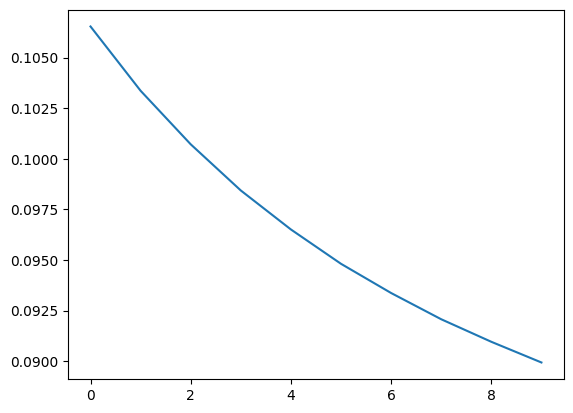

In [55]:
pd.Series(loss_per_epoch).plot()

In [56]:
batch_target

tensor([0.5600, 0.7200, 0.5200,  ..., 0.9000, 0.8000, 0.9000], device='cuda:0')

In [57]:
test_users = torch.LongTensor(interactions_test[:, 0]).to(device)
test_items = torch.LongTensor(interactions_test[:, 1]).to(device)


preds = model(test_users, test_items)
pred_numpy = preds.detach().cpu().numpy()

In [58]:
accuracy_score(pred_numpy >= 0.6, scores_test / 100.0 >= 0.6)

0.5116781322895663

In [59]:
roc_auc_score(scores_test / 100. >= 0.6, pred_numpy)

0.5069339947484498

In [60]:
pred_numpy

array([ 4.1691356 ,  0.58876723,  0.5177222 , ...,  0.3281446 ,
       -0.91954035,  0.6873753 ], dtype=float32)

In [61]:
scores_test

array([-1, 90, -1, ..., 90, -1, 90])